### Dataset Generation

This notebook takes you through all the steps in the Dataset generation process. 

We first start with pen-tip trajectories from the UCI Machine Learning repository's character trajectory dataset and subsequently transform it into spindle firing rates.

In [1]:
%matplotlib inline
import os
import h5py

import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import seaborn as sns

from pcr_data_utils import *
from generate_data import *

In [2]:
# Load processed datasets
with h5py.File('./pcr_startingpoints.hdf5', 'r') as file:
    startpts_horizontal = file['horizontal'][()]
    startpts_vertical = file['vertical'][()]
    
with h5py.File('./pcr_trajectories.hdf5', 'r') as file:
    data = file['trajectories'][()]
    labels = file['labels'][()]

**Original Pen-tip trajectories, upscaled to fit in a 10x10 grid.**

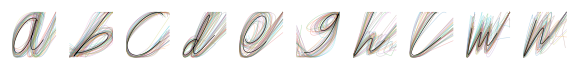

In [3]:
# Plot original trajectories, upscaled to fit in a 10x10cm grid
plt.figure(figsize=[10, 2])
for i in range(1,11):
    classdata = data[labels==i]
    plt.subplot(2, 10, i)
    for j in range(30):
        plt.plot(classdata[j][0, :], classdata[j][1, :], alpha=0.3, linewidth=0.5)
    plt.plot(np.mean(classdata, axis=0)[0, :], np.mean(classdata, axis=0)[1, :], 'k', linewidth=0.5)
    plt.xlim([-5.5, 5.5]); plt.ylim([-5.5, 5.5])
    plt.xticks([]); plt.yticks([]); 
    sns.despine(left=True, bottom=True)

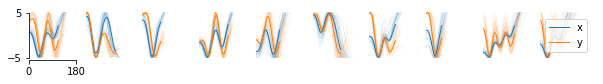

In [4]:
# Same as above, but as trajectories of x and y
plt.figure(figsize=[10, 2])
for i in range(1,11):
    classdata = data[labels==i]
    plt.subplot(2, 10, i)
    for j in range(30):
        plt.plot(classdata[j].T, alpha=0.1, linewidth=0.5)
        plt.gca().set_prop_cycle(None)
    plt.plot(np.mean(classdata, axis=0)[0].T, linewidth=1, label='x')
    plt.plot(np.mean(classdata, axis=0)[1].T, linewidth=1, label='y')
    plt.xlim([0, 180]); plt.xticks([0, 180]); plt.yticks([-5, 5])
    if i != 1:
        plt.gca().axis('off')
    else:
        sns.despine(trim=True)
    if i == 10:
        plt.legend()

**From pen-tip trajectory to end-effector trajectory: varying speed, rotation and scale.**

In [5]:
# Select a random trajectory in order to go through the steps of dataset generation
mytraj = data[90][:, np.all(~np.isnan(data[90]), axis=0)]

# Scale, rotate and vary the speed of the trajectory
scaled_mytraj = resize(mytraj, 1.3)
rotated_mytraj = apply_rotations(scaled_mytraj, 0, 0, 0)
slower_traj = speedify(rotated_mytraj, 0.8)

(0.0, 200.0, -9.0, 9.0)

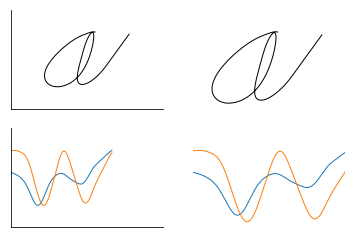

In [6]:
# Plot original and modified trajectories
plt.subplot(2, 2, 1)
plt.plot(mytraj[0], mytraj[1], 'k', linewidth=1)
plt.xlim([-9, 9]); plt.ylim([-9, 9]);
plt.xticks([]); plt.yticks([]);
sns.despine(ax=plt.gca())

plt.subplot(2, 2, 2)
plt.plot(slower_traj[0], slower_traj[1], 'k', linewidth=1)
plt.xlim([-9, 9]); plt.ylim([-9, 9]);
plt.xticks([]); plt.yticks([]);
plt.gca().axis('off')

plt.subplot(2, 2, 3)
plt.plot(mytraj.T, linewidth=1)
plt.xlim([0, 200]); plt.ylim([-9, 9]);
plt.xticks([]); plt.yticks([]);
sns.despine(ax=plt.gca())

plt.subplot(2, 2, 4)
plt.plot(slower_traj.T, linewidth=1)
plt.xlim([0, 200]); plt.ylim([-9, 9]);
plt.xticks([]); plt.yticks([]);
plt.gca().axis('off')

**Translate end-effector trajectory in the arm's workspace: Starting Points in Reachable workspace.**

Please see generate_startpoints.py to learn how to generate a grid of reachable workspace.

Text(0.5,0,'Z')

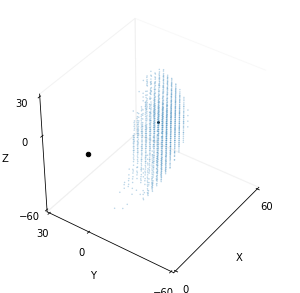

In [7]:
# Plot the reachable workspace
grid_resolution = 3   # in cm
xmax, xmin = 60, 0    # forward and backward
ymax, ymin = 30, -60  # left and right
zmax, zmin = 30, -60  # up and down

X = np.linspace(xmin, xmax, (xmax - xmin)//grid_resolution + 1)
Y = np.linspace(ymin, ymax, (ymax - ymin)//grid_resolution + 1)
Z = np.linspace(zmin, zmax, (zmax - zmin)//grid_resolution + 1)
x, y = np.meshgrid(Y, Z)

ax = plt.figure(figsize=[5, 5]).gca(projection='3d')
ax.scatter(startpts_vertical[:, 0], startpts_vertical[:, 1], startpts_vertical[:, 2], s=0.25, alpha=0.3)
ax.scatter([0], [0], [0], color='black')
ax.scatter(startpts_vertical[900, 0], startpts_vertical[900, 1], startpts_vertical[900, 2], s=3, color='black')
ax.set_xlim([xmin, xmax]); ax.set_ylim([ymin, ymax]); ax.set_zlim([zmin, zmax])
ax.xaxis.pane.fill = False; ax.yaxis.pane.fill = False; ax.zaxis.pane.fill = False
ax.view_init(elev=40, azim=-145)
ax.grid(False)
ax.set_xticks([0, 60]); ax.set_yticks([-60, 0, 30]); ax.set_zticks([-60, 0, 30])
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

**Translate end-effector trajectory into the arm's workspace.**

In [8]:
traj_3d = np.insert(slower_traj, 2, 0, axis=0)
plane_to_world = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 0]])
endeffector_coordinates = plane_to_world.dot(traj_3d) 
endeffector_coordinates += startpts_vertical[900][:, None]

Text(0.5,0,'Z')

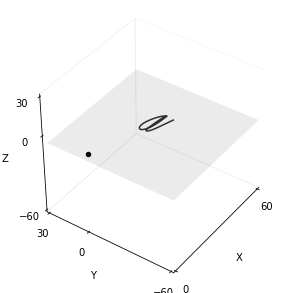

In [9]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=[5, 5])

plane = np.where(np.std(endeffector_coordinates, axis=1) < 1e-5)[0][0]
if plane == 0:
    y, z = np.meshgrid(Y, Z)
    x = np.zeros_like(y) + endeffector_coordinates[plane, 0]
elif plane == 2:
    x, y = np.meshgrid(X, Y)
    z = np.zeros_like(y) + endeffector_coordinates[plane, 0]    
    
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, z, color='gray', alpha=0.1)
ax.plot(endeffector_coordinates[0], endeffector_coordinates[1], endeffector_coordinates[2], color='k', alpha=0.8)
ax.scatter([0], [0], [0], color='black')
ax.set_xlim([xmin, xmax]); ax.set_ylim([ymin, ymax]); ax.set_zlim([zmin, zmax])
ax.xaxis.pane.fill = False; ax.yaxis.pane.fill = False; ax.zaxis.pane.fill = False
ax.view_init(elev=40, azim=-145)
ax.grid(False)
ax.set_xticks([0, 60]); ax.set_yticks([-60, 0, 30]); ax.set_zticks([-60, 0, 30])
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

**Derive Joint angle configurations for the generated endeffector trajectory.**

In [10]:
joint_traj, error = make_joint_config(endeffector_coordinates)

myarm = Arm()
shoulder_to_world = np.array([[0, 0, -1], [-1, 0, 0], [0, 1, 0]])

Text(0.5,0,'Z')

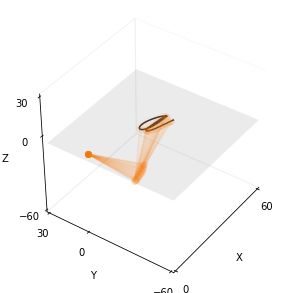

In [11]:
fig = plt.figure(figsize=[5, 5])
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, z, color='gray', alpha=0.1)
ax.plot(endeffector_coordinates[0], endeffector_coordinates[1], endeffector_coordinates[2], color='k', alpha=0.8)

for i in range(endeffector_coordinates.shape[1]//5):
    try: 
        pos = endeffector_coordinates[:, i*5]
        link_pos = shoulder_to_world.dot(myarm.get_xyz(joint_traj[:, i*5])[1])
        ax.plot(link_pos[0, :], link_pos[1, :], link_pos[2, :], marker='o', color='C1', alpha=(i/300))
    except:
        break

ax.scatter([0], [0], [0], color='black')
ax.set_xlim([xmin, xmax]); ax.set_ylim([ymin, ymax]); ax.set_zlim([zmin, zmax])
ax.xaxis.pane.fill = False; ax.yaxis.pane.fill = False; ax.zaxis.pane.fill = False
ax.view_init(elev=40, azim=-145)
ax.grid(False)
ax.set_xticks([0, 60]); ax.set_yticks([-60, 0, 30]); ax.set_zticks([-60, 0, 30])
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

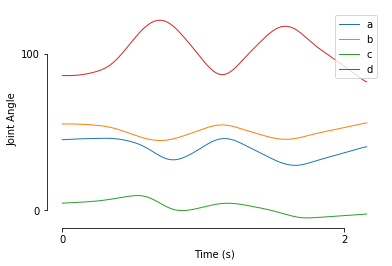

In [12]:
# Plot joint angles as trajectories in time
plt.plot(joint_traj.T, linewidth=1)
plt.xticks([0, 200], [0, 2]); plt.yticks([0, 100])
plt.xlabel('Time (s)'); plt.ylabel('Joint Angle')
plt.legend(('a', 'b', 'c', 'd'))
sns.despine(trim=True)

**Generate muscle configurations from joint configurations.**

In [13]:
import opensim as osim
mymodel = osim.Model('./MoBL_ARMS_module5_scaleIK.osim')
muscle_config = make_muscle_config(mymodel, joint_traj)

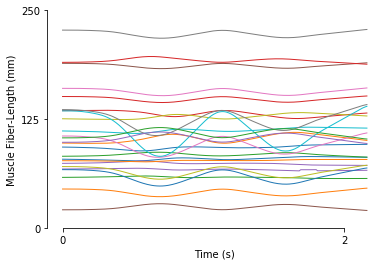

In [14]:
plt.plot(muscle_config.T, linewidth=1)
plt.xticks([0, 200], [0, 2]); plt.yticks([0, 125, 250])
plt.xlabel('Time (s)'); plt.ylabel('Muscle Fiber-Length (mm)')
sns.despine(trim=True)

**Generate spindle firing rates from muscle configurations based on the Prochazka Gorassini Model.**

In [15]:
def signpow(a,b): return np.sign(a)*(np.abs(a)**b)

def make_spindle_coords(muscle_traj):
    stretch = np.gradient(muscle_traj, 1, axis=1)
    stretch_vel = np.gradient(muscle_traj, 0.02, axis=1)
    p_rate = 2*stretch + 4.3*signpow(stretch_vel, 0.6)
    return p_rate

spindle_config = make_spindle_coords(muscle_config)

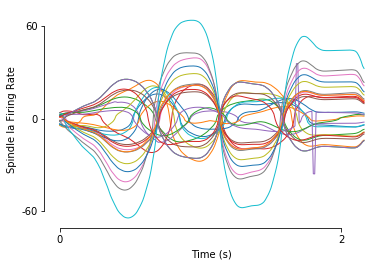

In [16]:
plt.plot(spindle_config.T, linewidth=1)
plt.xticks([0, 200], [0, 2]); 
plt.yticks((-60, 0, 60), (-60, 0, 60))
plt.xlabel('Time (s)'); plt.ylabel('Spindle Ia Firing Rate')
sns.despine(trim=True)

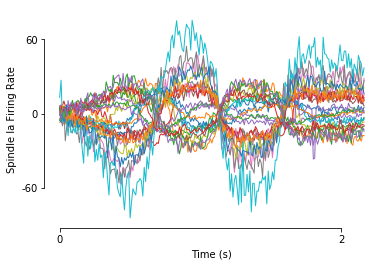

In [17]:
# Add gaussian noise to the spindle firing rate trajectory.
spindle_noisy = add_noise(spindle_config, 0.2)
plt.plot((spindle_noisy - np.mean(spindle_noisy, axis=1)[:, None]).T, linewidth=1)
plt.xticks([0, 200], [0, 2]); 
plt.yticks((-60, 0, 60), (-60, 0, 60))
plt.xlabel('Time (s)'); plt.ylabel('Spindle Ia Firing Rate')
sns.despine(trim=True)